 # Opis notatnika
 Zmierzamy do końca analizy danych, które zostały nam udostępnione. Ten krok dodaje jeszcze więcej informacji do naszego wyjściowego zbioru. Tym razem sprawdzimy między innymi to, czy opóźnienia lotów zależne są od trasy czy warunków pogodowych.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednich krokach, skonfigurować odpowiednio notatnik.
 
 W tej części warsztatu ponownie wcielasz się w rolę Analiyka Danych, którego zadaniem jest wykonanie analizy eksplotacyjnej zbioru danych - jedno z wymagań dostarczonych przez klienta.

 Tutaj zaimportuj wymagane biblioteki

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
from sqlalchemy import create_engine

 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [2]:
username = 'postgres'
password = 'kmiotek123'
host = 'localhost'
database = 'airlines'
port = 5432

 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [3]:
url = f'postgresql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [4]:
#df = pd.read_sql_table('table_name', engine)

 Tutaj zaczytaj zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [5]:
path = r'C:\Users\Maciek\Desktop\projekt_koncowy\Koncowego_sprawdzony\data\processed'
file_name = 'flight_df_01.csv'
flight_df = pd.read_csv(f'{path}/{file_name}')

print(flight_df.head())

        id  month  day_of_month  day_of_week op_unique_carrier tail_num  \
0  2183121      3             1            5                WN   N224WN   
1  2183122      3             1            5                WN   N8549Z   
2  2183123      3             1            5                WN   N8691A   
3  2183124      3             1            5                WN   N447WN   
4  2183125      3             1            5                WN   N283WN   

   op_carrier_fl_num  origin_airport_id  dest_airport_id  crs_dep_time  ...  \
0                106              12892            10397           945  ...   
1               1397              12892            10397          1310  ...   
2               1993              12892            10397           735  ...   
3               1170              12892            11292          1900  ...   
4               1256              12892            11292          1745  ...   

   distance_group  carrier_delay weather_delay  nas_delay  security_delay 

 # Wzbogacenie o `airport_list`
 Wczytaj do obszaru roboczego tabelę `airport_list` używając procedury `read_sql_table`. Wykonaj poniższe ćwiczenia:  
 1. Sprawdź, czy klucz `origin_airport_id` jest unikalny, tj. nie ma dwóch takich samych wartości w kolumnie `origin_airport_id`.  
 1. Jeżeli duplikaty występują, usuń je w najdogodniejszy dla Ciebie sposób.  
 1. Jeśli duplikaty nie występują, złącz ramki `airport_list_df` wraz z aktualną `flight_df`, używając kolumny `origin_airport_id` oraz złączenia typu `LEFT JOIN`. Z ramki `airport_list_df` interesuje nas dodanie kolumny `origin_city_name`.  
 1. Dodatkowo dokonaj jeszcze raz złączenia ramki `flight_df` z `airport_list_df`, tym razem jednak złącz kolumnę `destination_airport_id` wraz z `origin_airport_id`. Podobnie jak wcześniej, interesuje nas kolumna `origin_city_name`, jedank ona powinna zostać wyświetlona jako `destination_city_name`

 Tutaj wczytaj ramkę `airport_list_df`

In [6]:
airport_list_df = pd.read_sql_table('airport_list', engine)
print(airport_list_df.head())

    id  origin_airport_id            display_airport_name origin_city_name  \
0   98              11638             Fresno Air Terminal       Fresno, CA   
1   99              13342          General Mitchell Field    Milwaukee, WI   
2  100              13244           Memphis International      Memphis, TN   
3  101              15096  Syracuse Hancock International     Syracuse, NY   
4  102              10397               Atlanta Municipal      Atlanta, GA   

                                                name  
0               FRESNO YOSEMITE INTERNATIONAL, CA US  
1                  MILWAUKEE MITCHELL AIRPORT, WI US  
2               MEMPHIS INTERNATIONAL AIRPORT, TN US  
3      SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US  
4  ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...  


 Tutaj sprawdż, czy występują duplikaty dla kolumny `origin_airport_id`

In [7]:
print(airport_list_df['origin_airport_id'].duplicated().any())

False


 Tutaj usuń duplikaty – jeśli występują

In [8]:
airport_list_df.drop_duplicates(subset=['origin_airport_id'], inplace=True)

 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `origin_airport_id`

In [9]:
flight_df = flight_df.merge(airport_list_df[['origin_airport_id', 'origin_city_name']], on='origin_airport_id', how='left')
print(flight_df.head())
print(flight_df.info())

        id  month  day_of_month  day_of_week op_unique_carrier tail_num  \
0  2183121      3             1            5                WN   N224WN   
1  2183122      3             1            5                WN   N8549Z   
2  2183123      3             1            5                WN   N8691A   
3  2183124      3             1            5                WN   N447WN   
4  2183125      3             1            5                WN   N283WN   

   op_carrier_fl_num  origin_airport_id  dest_airport_id  crs_dep_time  ...  \
0                106              12892            10397           945  ...   
1               1397              12892            10397          1310  ...   
2               1993              12892            10397           735  ...   
3               1170              12892            11292          1900  ...   
4               1256              12892            11292          1745  ...   

   carrier_delay  weather_delay nas_delay  security_delay  \
0            

 Tutaj dokonaj złączenia ramki `flight_df` oraz `airport_list_df` używając `destination_airport_id`

In [10]:
# Połączenie z airport_list_df po dest_airport_id
flight_df = flight_df.merge(airport_list_df[['origin_airport_id', 'origin_city_name']], left_on='dest_airport_id', right_on='origin_airport_id', how='left')

# Zmiana nazwy kolumny 'origin_city_name' na 'destination_city_name'
flight_df = flight_df.rename(columns={'origin_city_name_y': 'destination_city_name'})
flight_df = flight_df.rename(columns={'origin_city_name_x': 'origin_city_name'})
flight_df = flight_df.rename(columns={'origin_airport_id_x': 'origin_airport'})
flight_df.drop('origin_airport_id_y', axis=1, inplace=True)
print(flight_df.info())

print(flight_df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057391 entries, 0 to 1057390
Data columns (total 33 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1057391 non-null  int64  
 1   month                  1057391 non-null  int64  
 2   day_of_month           1057391 non-null  int64  
 3   day_of_week            1057391 non-null  int64  
 4   op_unique_carrier      1057391 non-null  object 
 5   tail_num               1057391 non-null  object 
 6   op_carrier_fl_num      1057391 non-null  int64  
 7   origin_airport         1057391 non-null  int64  
 8   dest_airport_id        1057391 non-null  int64  
 9   crs_dep_time           1057391 non-null  int64  
 10  dep_time               1057391 non-null  float64
 11  dep_delay              1057391 non-null  float64
 12  dep_time_blk           1057391 non-null  object 
 13  crs_arr_time           1057391 non-null  int64  
 14  arr_time          

### Sprawdzenie
Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [11]:
assert 'origin_city_name' in flight_df.columns, 'Brak kolumny `origin_city_name` w ramce flight_df'
assert 'destination_city_name' in flight_df.columns, 'Brak kolumny `destination_city_name` w ramce flight_df'

flight_df_expected_rows_amount = 1057391
assert flight_df.shape[0] == flight_df_expected_rows_amount, 'Ups, zmieniła się liczba wierszy...'

 ## Analiza według lotnisk oraz tras
 Wykonaj poniższe polecenia:  
 1. Wyznacz lotniska, z których **odlatywało** najwięcej samolotów. Wynik zapisz do ramki `top_airports_origin_df`.
 1. Wyznacz lotnika, na których najwięcej lotów **się kończyło**. Wynik zapisz do ramki `top_airports_destination_df`.  
 1. Wyznacz najczęściej uczęszczaną trasę, wynik zapisz do ramki `top_route_df`.  
 1. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, wyznacz dodatkowo top 10:  
     - tras z **najmniejszym odsetkiem opóźnień**, wynik zapisz do ramki `least_route_delays_df`.  
     - tras z **największym odsetkiem opóźnień**, wynik zapisz do ramki `top_route_delays_df`.

 Tutaj wyznacz ramkę `top_airports_origin_df`

In [12]:
# znalezienie lotnisk z największa liczbą odlotów
top_airports_origin_df = flight_df.groupby("origin_airport")["id"].count().nlargest(10).reset_index()
top_airports_origin_df = top_airports_origin_df.rename(columns={"id": "count"})


 Tutaj wyznacz ramkę `top_airports_destination_df`

In [13]:
# znalezienie lotnisk z największa liczbą przylotów
top_airports_destination_df = flight_df.groupby("dest_airport_id")["id"].count().nlargest(10).reset_index()
top_airports_destination_df = top_airports_destination_df.rename(columns={"id": "count"})


In [14]:
# znalezienie najczęściej uczęszczanej trasy
top_route_df = flight_df.groupby(["origin_airport", "dest_airport_id"])["id"].count().nlargest(1).reset_index()

# znalezienie trasy gdzie są najmniejsze oóźnienia (dla trasy >500 lotów)
delay_counts_df = flight_df.groupby(["origin_airport", "dest_airport_id", "is_delayed"])["id"].count().reset_index()
delay_counts_df = delay_counts_df.pivot_table(index=["origin_airport", "dest_airport_id"], columns="is_delayed", values="id", fill_value=0).reset_index()
delay_counts_df["delay_percentage"] = delay_counts_df[True] * 100 / (delay_counts_df[True] + delay_counts_df[False])
least_route_delays_df = delay_counts_df[delay_counts_df[False] + delay_counts_df[True] > 500].nsmallest(10, "delay_percentage")

# znalezienie trasy gdzie są największe oóźnienia (dla trasy >500 lotów)
top_routes = top_route_df[["origin_airport", "dest_airport_id"]]
top_route_delays_df = delay_counts_df[delay_counts_df[False] + delay_counts_df[True] > 500].merge(top_routes, on=["origin_airport", "dest_airport_id"])
top_route_delays_df = top_route_delays_df.nlargest(10, "delay_percentage")


 ### Sprawdzenie dla `top_airport_origin`

### Sprawdzenie dla `top_airport_destination`

In [15]:
top_airports_destination_df = (flight_df
                               .groupby(by=['dest_airport_id']).size()
                               )
top_airports_destination_df

top_airports_destination_head = (top_airports_destination_df
                                 .sort_values(ascending=False)
                                 .head()
                                 .to_list()
                                 )
top_airports_destination_head = tuple(top_airports_destination_head)
top_airports_destination_head_expected = (122945, 100333, 87776, 64602, 57686)

assert top_airports_destination_head == top_airports_destination_head_expected, f"Nie zgadza się top 5 wierszy, oczekiwano wyników: {top_airports_destination_head_expected} otrzymano: {top_airports_destination_head}"

 # Wzbogacenie o dane pogodowe
 Używając procedury `read_sql_table`, wczytaj tabelę `airport_weather` do ramki `airport_weather_df`. Następnie wykonaj następujące polecenia:  
 1. Pozostaw w ramce tylko następujące kolumny: `['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']`.  
 1. Połącz ramki `airport_list_df` wraz z `airport_weather_df` po odpowiedniej kolumnie używając takiego złączenia, aby w wyniku usunąć te wiersze (lotniska), które nie posiadają danych pogodowych. Dodatkowo, upewnij się, że zostanie tylko dodana kolumna `origin_airport_id`.

 Tutaj wczytaj ramkę `airport_weather`

In [16]:
airport_weather_df = pd.read_sql_table('airport_weather', engine)
airport_weather_df.head()
#airport_weather_df.info()

,id,station,name,date,awnd,pgtm,prcp,snow,snwd,tavg,...,wt09,wesd,wt10,psun,tsun,sn32,sx32,tobs,wt11,wt18
0,47829,USW00013970,"BATON ROUGE METRO AIRPORT, LA US",2019-01-22,12.30,NaN,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48250,USW00094054,"BUFFALO JOHNSON CO AIRPORT, WY US",2019-01-09,6.49,NaN,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48251,USW00094054,"BUFFALO JOHNSON CO AIRPORT, WY US",2019-01-10,6.71,NaN,0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48252,USW00094054,"BUFFALO JOHNSON CO AIRPORT, WY US",2019-01-11,10.96,NaN,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48253,USW00094054,"BUFFALO JOHNSON CO AIRPORT, WY US",2019-01-12,6.93,NaN,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Tutaj oczyść ramkę `airport_weather_df` z nadmiarowych kolumn

In [17]:
airport_list_df.head()
#airport_list_df.info()

,id,origin_airport_id,display_airport_name,origin_city_name,name
0,98,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US"
1,99,13342,General Mitchell Field,"Milwaukee, WI","MILWAUKEE MITCHELL AIRPORT, WI US"
2,100,13244,Memphis International,"Memphis, TN","MEMPHIS INTERNATIONAL AIRPORT, TN US"
3,101,15096,Syracuse Hancock International,"Syracuse, NY","SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US"
4,102,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


 Tutaj połącz ramki `airport_list_df` oraz `airport_weather_df` aktualizując `airport_weather_df`

In [18]:
# połączenie airport_weather_df z airport_list_df
merged_df = pd.merge(airport_weather_df, airport_list_df[['name', 'origin_airport_id']], on='name', how='left')

# usunięcie lotniks dla których brakuje danych pogodowych o kolumnie "origin_airport_id"
merged_df.dropna(subset=['origin_airport_id'], inplace=True)

# pozostawienie wskazanych kolumn + origin_airport_id
airport_weather_df = merged_df.loc[:, ['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd', 'origin_airport_id']]


In [19]:
#merged_df.info()
airport_weather_df.head()

,station,name,date,prcp,snow,snwd,tmax,awnd,origin_airport_id
6,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70,10397.0
7,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92,10397.0
8,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37,10397.0
9,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08,10397.0
10,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42,10397.0


 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [20]:
airport_weather_df_expected_shape = (43394, 9)
airport_weather_df_shape = airport_weather_df.shape

assert airport_weather_df_expected_shape == airport_weather_df_shape, \
  f'Nieodpowiedni wymiar ramki airport_weather_df, oczekiwano (wierszy, kolumn): {airport_weather_df_expected_shape}'


 ## Połączenie `airport_weather_df` oraz `flight_df`
 W celu złączenia ramek `airport_weather_df` oraz `flight_df` wykonaj następujące kroki:  
 1. w ramce `aiport_weather_df` występuje kolumna `date`, zrzutuj ją na typ `DATETIME`.  
 1. w ramce `flight_df` należy stworzyć nową kolumnę o nazwie `date`. W tym celu:  
 	- złącz kolumny `month`, `day_of_month` oraz `year` razem, użyj następującego formatu daty: `YYYY-MM-DD`.
 	- zrzutuj kolumnę `date` na typ `DATETIME`.  
 1. złącz ramki używając odpowiedniego klucza, wynik złączenia zapisz do ramki `flight_df`. Użyj złącznia typu `LEFT JOIN`.

 > Dlaczego istotne jest zachowanie typów przy złączeniu?

W trakcie pracy możesz posłużyć się następującymi artykułami z `LMS`:
 - `Python - analiza danych > Dzień 6 - Pandas > Merge`
 - `Python - analiza danych > Dzień 6 - Pandas > Praca z datetime`
 - Dokumentacje metody `to_datetime`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
 - Dostępne formaty dat: [klik](https://www.programiz.com/python-programming/datetime/strftime) - sekcja `Format Code List`

 Tutaj zrzutuj kolumnę `date` na `DATETIME` w ramce `airport_weather_df`

In [21]:
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'])
#print(airport_weather_df.head())

 Tutaj stwórz kolumnę `date` w ramce `flight_df`. Pamiętaj, aby była ona również typu `DATETIME`.

In [22]:
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day_of_month']].astype(str).agg('-'.join, axis=1))

# zmiana typu kolumny date na typ DATETIME
flight_df['date'] = pd.to_datetime(flight_df['date'])

In [23]:
print(flight_df.head())

        id  month  day_of_month  day_of_week op_unique_carrier tail_num  \
0  2183121      3             1            5                WN   N224WN   
1  2183122      3             1            5                WN   N8549Z   
2  2183123      3             1            5                WN   N8691A   
3  2183124      3             1            5                WN   N447WN   
4  2183125      3             1            5                WN   N283WN   

   op_carrier_fl_num  origin_airport  dest_airport_id  crs_dep_time  ...  \
0                106           12892            10397           945  ...   
1               1397           12892            10397          1310  ...   
2               1993           12892            10397           735  ...   
3               1170           12892            11292          1900  ...   
4               1256           12892            11292          1745  ...   

   nas_delay  security_delay late_aircraft_delay  year  is_delayed  \
0        NaN          

 Tutaj złącz tabeli `airport_weather_df` oraz `flight_df`

In [24]:
flight_df = pd.merge(flight_df, airport_weather_df, how='left', left_on=['origin_airport', 'date'], right_on=['origin_airport_id', 'date'])

In [25]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057391 entries, 0 to 1057390
Data columns (total 42 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id                     1057391 non-null  int64         
 1   month                  1057391 non-null  int64         
 2   day_of_month           1057391 non-null  int64         
 3   day_of_week            1057391 non-null  int64         
 4   op_unique_carrier      1057391 non-null  object        
 5   tail_num               1057391 non-null  object        
 6   op_carrier_fl_num      1057391 non-null  int64         
 7   origin_airport         1057391 non-null  int64         
 8   dest_airport_id        1057391 non-null  int64         
 9   crs_dep_time           1057391 non-null  int64         
 10  dep_time               1057391 non-null  float64       
 11  dep_delay              1057391 non-null  float64       
 12  dep_time_blk           10573

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [26]:
flight_df_expected_rows_amount = 1057391
assert flight_df.shape[0] == flight_df_expected_rows_amount, 'Ups, zmieniła się liczba wierszy...'


# Praca samodzielna
Używając `flight_df` zbadaj hipotezę o tym, że temperatura maksymalna wpływa na **odsetek** opóźnień lotów (kolumna `tmax`).  

Przy wykonywaniu tego zadania masz pełną dowolność, jednak powinno składać się conajmniej z następujących elementów:
- sprawdzenie, czy zmienna posiada obserwacje odstające,
- oczyszczenie danych o ile konieczne,
- przedstawienie w formie tabeli czy wzrost danej zmiennej powoduje zmianę w odsetku opóźnień lotów,
- wizualizację stworzonej wcześniej tabeli w formie wykresu,
- krótkiego opisu wyników w komórce markdown.

 ## Analiza dla kolumny `tmax`

Przed rozpoczęciem analizy warto też sprawdzić, czy kolumna tmax nie posiada obserwacji odstających. Możemy to zrobić np. poprzez wyświetlenie histogramu tej zmiennej i zobaczenie, czy występują w nim wartości skrajne.

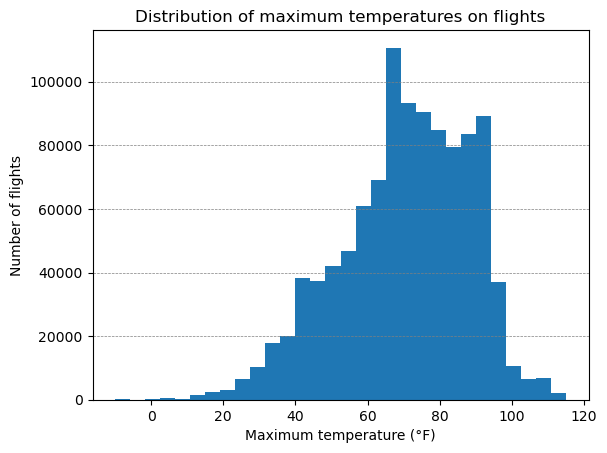

In [38]:
plt.hist(flight_df['tmax'], bins=30)
plt.title('Distribution of maximum temperatures on flights')
plt.xlabel('Maximum temperature (°F)')
plt.ylabel('Number of flights')

plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
plt.show()

Widzimy, że histogram temperatury maksymalnej jest dość symetryczny i nie zawiera wartości skrajnych, co oznacza, że nie musimy usuwać żadnych obserwacji.

Usunięcie wierszey, w których ewentualnie brakuje danych w kolumnie 'tmax'

In [28]:
flight_df.dropna(subset=['tmax'], inplace=True)

In [29]:
# utworzenie przedziałów temperatury maksymalnej
temp_bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)])

In [30]:
# dodanie kolumny z przedziałami temperatury maksymalnej do ramki danych
flight_df['temp_range'] = pd.cut(flight_df['tmax'], bins=temp_bins)

In [31]:
# obliczenie średniego odsetka opóźnień dla każdego przedziału temperatury maksymalnej
delayed_by_temp = flight_df.groupby('temp_range')['is_delayed'].mean()

In [32]:
# wyświetlenie wyników 
delayed_by_temp.round(2)

temp_range
(0, 10]      0.42
(10, 20]     0.32
(20, 30]     0.25
(30, 40]     0.24
(40, 50]     0.19
(50, 60]     0.19
(60, 70]     0.18
(70, 80]     0.18
(80, 90]     0.19
(90, 100]    0.20
Name: is_delayed, dtype: float64

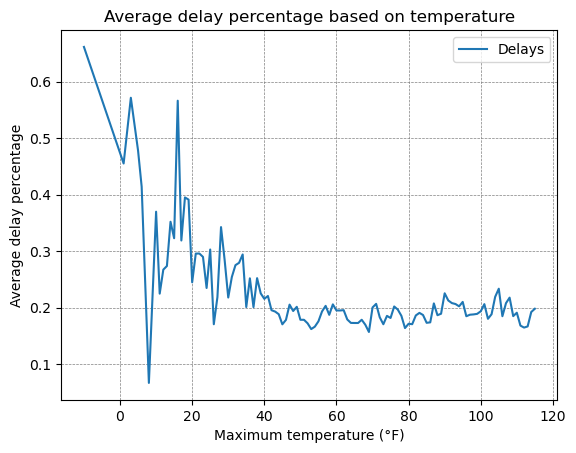

In [41]:
# grupowanie po kolumnie tmax i obliczenie średniej wartości dla kolumny is_delayed
delayed_by_temp = flight_df.groupby('tmax')['is_delayed'].mean()

# konwersja wyniku grupowania na ramkę danych
delayed_by_temp = delayed_by_temp.reset_index()

# wykres liniowy
delayed_by_temp.plot(x='tmax', y='is_delayed', kind='line', label='Delays')

plt.title('Average delay percentage based on temperature')
plt.xlabel('Maximum temperature (°F)')
plt.ylabel('Average delay percentage')

plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

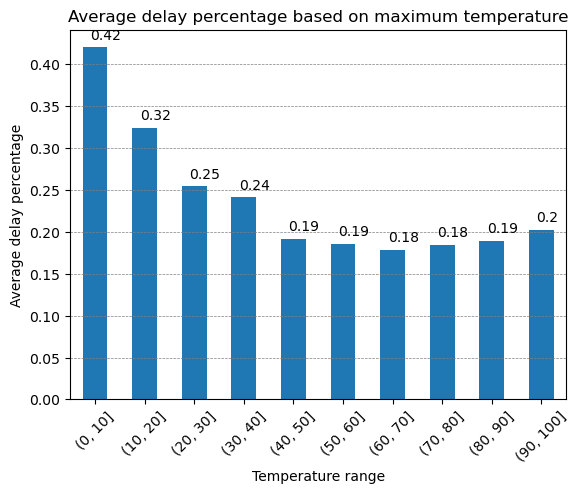

In [44]:
# grupowanie danych i obliczenie średniego odsetka opóźnień dla każdego przedziału temperatury maksymalnej
delayed_by_temp = flight_df.groupby('temp_range')['is_delayed'].mean()

# utworzenie wykresu słupkowego z zaokrąglonymi wartościami na końcach kolumny
ax = delayed_by_temp.plot(kind='bar')
for i, v in enumerate(delayed_by_temp):
    ax.text(i - 0.1, v + 0.01, str(round(v, 2)))

plt.title('Average delay percentage based on maximum temperature')
plt.xlabel('Temperature range')
plt.ylabel('Average delay percentage')
plt.xticks(rotation=45)

plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# wyświetlenie wykresu
plt.show()

## Miejsce na Twój komentarz

Hipoteza o tym, że temperatura maksymalna wpływa na odsetek opóźnień lotów jest prawdzia. Powyższe wykresy udowadniają, ze im temperatura powietrza jest niższa, tym większy jest odsetek opóźnionych lotów. Wraz ze wzostem temperatury odsetek opóźnień spada o ponad połowe wzglem najniższych temperatur. Powyżej temperatury 40°F odsetek opóźnień stablizuje się w przedziale 0.18-0.2. 

# Podsumowanie
W tej części warsztatu dokonaliśmy kompleksowej analizy posiadanego zbioru danych. Eksploracja
pozwoliła nam na zapoznanie się z cechami charakterystycznymi lotów - wiemy już, które 
zmienne mogą mieć wpływ na opóźnienia lotów, a które nie. Co warto podkreślić, skupiliśmy się na wielu
aspektach tej analizy, co otwiera potencjalnie również inne możliwości dalszej pracy nad tą bazą.

W tym momencie przejdziemy do kolejnego kroku, w którym, na podstawie tej analizy, przygotujemy 
system raportowy. Zanim jednak stworzymy dashboard, potrzebujemy zaktualizować naszą bazę danych.